
<img src="../../img/ods_stickers.jpg">

## <center> [mlcourse.ai](https://mlcourse.ai) – открытый курс OpenDataScience по машинному обучению 
    
Автор материала: Мария Мансурова, аналитик-разработчик в команде Яндекс.Метрики. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Домашнее задание № 9. (демо)
## <center> Анализ временных рядов
    
**Заполните пропущенный код и ответьте на вопросы в [онлайн-форме](https://docs.google.com/forms/d/1ijk4aFKY5plPiI8z3Mgi3i1Ln94VBY9SSt6xGIdVVFQ/).**

In [17]:
import os
os.environ['NUMEXPR_MAX_THREADS'] = '10'
import numpy as np
import pandas as pd
import requests
from plotly import __version__
from plotly import graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot

print(__version__)  # need 1.9.0 or greater

init_notebook_mode(connected=True)


def plotly_df(df, title=""):
    data = []

    for column in df.columns:
        trace = go.Scatter(x=df.index, y=df[column], mode="lines", name=column)
        data.append(trace)

    layout = dict(title=title)
    fig = dict(data=data, layout=layout)
    iplot(fig, show_link=False)

4.14.3


## Подготавливаем данные

Для начала скачаем данные в `dataframe`. Сегодня будем предсказывать просмотры wiki-страницы [Machine Learning](https://en.wikipedia.org/wiki/Machine_learning). Данные я скачала с помощью библиотеки [Wikipediatrend](https://www.r-bloggers.com/using-wikipediatrend/) для `R`.

In [2]:
df = pd.read_csv("D:\\Scrapers_and_data_work\\Neural_Network_Habr\\wiki_machine_learning.csv", sep=" ")
df = df[df["count"] != 0]
df.head()

,date,count,lang,page,rank,month,title
81,2015-01-01,1414,en,Machine_learning,8708,201501,Machine_learning
80,2015-01-02,1920,en,Machine_learning,8708,201501,Machine_learning
79,2015-01-03,1338,en,Machine_learning,8708,201501,Machine_learning
78,2015-01-04,1404,en,Machine_learning,8708,201501,Machine_learning
77,2015-01-05,2264,en,Machine_learning,8708,201501,Machine_learning


In [3]:
df.shape

(383, 7)

In [4]:
df.date = pd.to_datetime(df.date)

In [5]:
plotly_df(df.set_index("date")[["count"]])

## Предсказание с помощью Facebook Prophet

Для начала построим предсказание с помощью простой библиотеки `Facebook Prophet`. Для того, чтобы посмотреть на качество модели, отбросим из обучающей выборки последние 30 дней.

In [6]:
from fbprophet import Prophet

In [7]:
predictions = 30

df = df[["date", "count"]]
df.columns = ["ds", "y"]
train_df = df[:-predictions].copy()
df.tail()

In [8]:
#Prophet?

In [9]:
%%time
m = Prophet()
m.fit(train_df);

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Wall time: 2.07 s


In [10]:
future = m.make_future_dataframe(periods=30)
future.tail()

,ds
378,2016-01-16
379,2016-01-17
380,2016-01-18
381,2016-01-19
382,2016-01-20


In [11]:
forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
378,2016-01-16,2971.125440,1706.346411,2497.900751,2949.771198,2988.567358,-861.666255,-861.666255,-861.666255,-861.666255,-861.666255,-861.666255,0.0,0.0,0.0,2109.459185
379,2016-01-17,2976.423576,1868.394554,2643.294085,2953.410018,2995.471619,-720.685978,-720.685978,-720.685978,-720.685978,-720.685978,-720.685978,0.0,0.0,0.0,2255.737598
380,2016-01-18,2981.721713,2850.222886,3677.347504,2957.639325,3001.861634,281.426215,281.426215,281.426215,281.426215,281.426215,281.426215,0.0,0.0,0.0,3263.147928
381,2016-01-19,2987.019849,3137.947547,3948.819603,2961.256395,3007.968342,541.366440,541.366440,541.366440,541.366440,541.366440,541.366440,0.0,0.0,0.0,3528.386289
382,2016-01-20,2992.317986,3024.935999,3807.849827,2965.652375,3014.714687,425.464520,425.464520,425.464520,425.464520,425.464520,425.464520,0.0,0.0,0.0,3417.782506


In [12]:
print(", ".join(forecast.columns))

ds, trend, yhat_lower, yhat_upper, trend_lower, trend_upper, additive_terms, additive_terms_lower, additive_terms_upper, weekly, weekly_lower, weekly_upper, multiplicative_terms, multiplicative_terms_lower, multiplicative_terms_upper, yhat


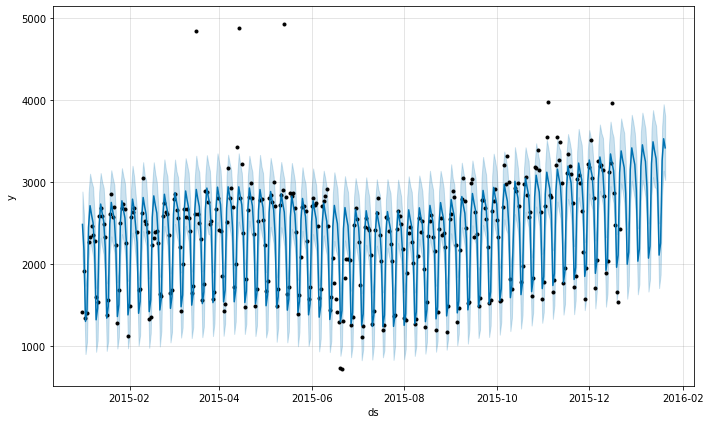

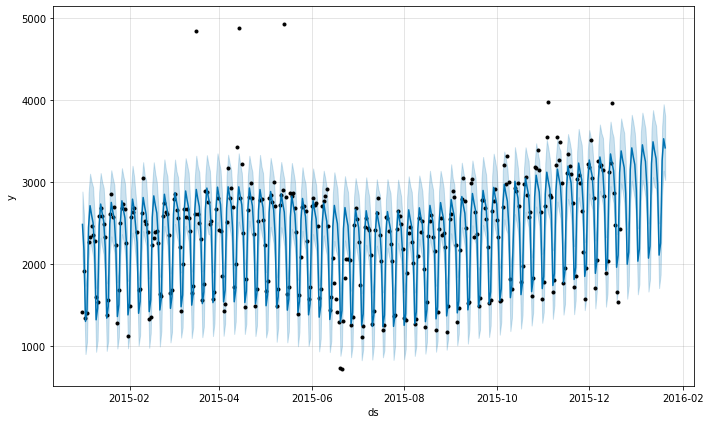

In [13]:
m.plot(forecast)

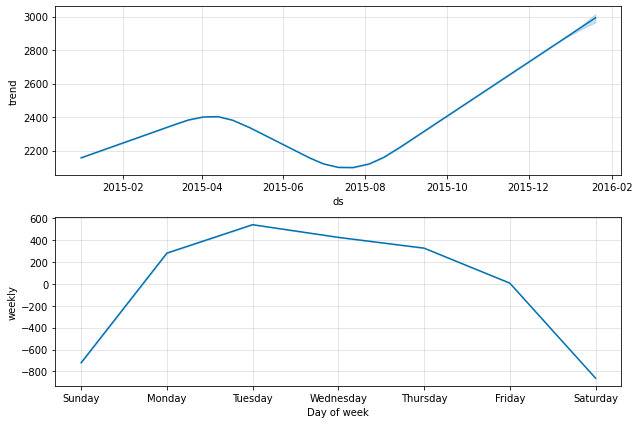

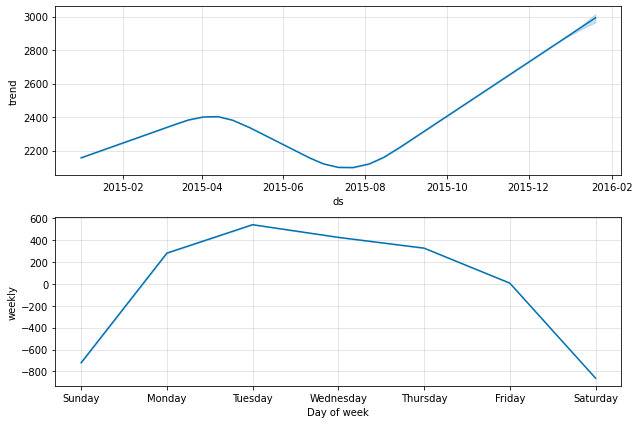

In [14]:
m.plot_components(forecast)

**Вопрос 1:** Какое предсказание числа просмотров wiki-страницы на 20 января? Ответ округлите до целого числа.
- 3559

Оценим качество предсказания по последним 30 точкам.

In [15]:
cmp_df = forecast.set_index("ds")[["yhat", "yhat_lower", "yhat_upper"]].join(
    df.set_index("ds")
)

In [18]:
cmp_df["e"] = cmp_df["y"] - cmp_df["yhat"]
cmp_df["p"] = 100 * cmp_df["e"] / cmp_df["y"]
print("MAPE = ", round(np.mean(abs(cmp_df[-predictions:]["p"])), 2))
print("MAE = ", round(np.mean(abs(cmp_df[-predictions:]["e"])), 2))

MAPE =  34.19
MAE =  593.37


**Вопрос 2**: Какое получилось MAPE?

- 34

**Вопрос 3**: Какое получилось MAE?

- 593


## Предсказываем с помощью ARIMA

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

plt.rcParams["figure.figsize"] = (15, 10)

**Вопрос 4:** Проверим стационарность ряда с помощью критерия Дики-Фулера. Является ли ряд стационарным? Какое значение p-value?

- p=0.107392

Dickey-Fuller test: p=0.107392


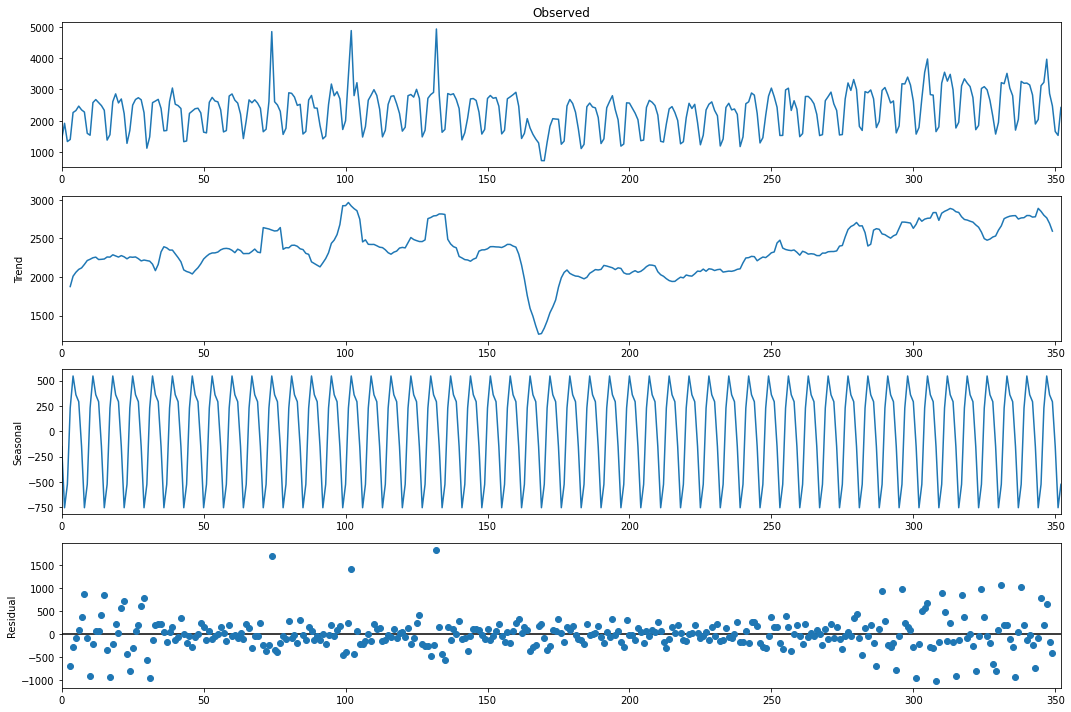

In [20]:
sm.tsa.seasonal_decompose(train_df["y"].values, freq=7).plot()
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(train_df["y"])[1])

In [22]:
train_df.set_index("ds", inplace=True)

Dickey-Fuller test: p=0.000000


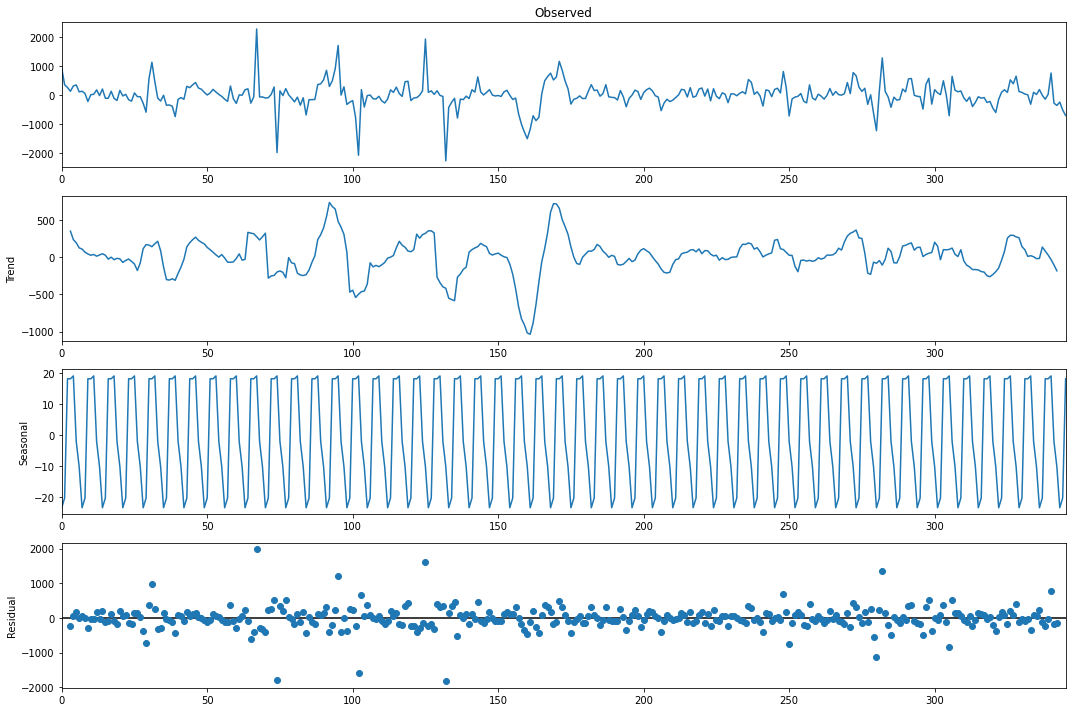

In [23]:
train_df["y_diff"] = train_df.y - train_df.y.shift(7)
sm.tsa.seasonal_decompose(train_df.y_diff[7:].values, freq=7).plot()
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(train_df.y_diff[8:])[1])

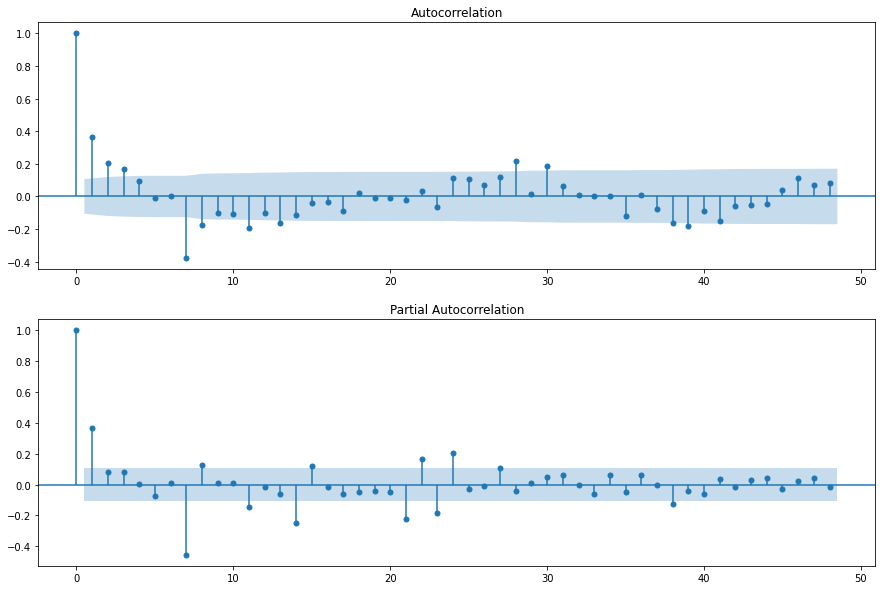

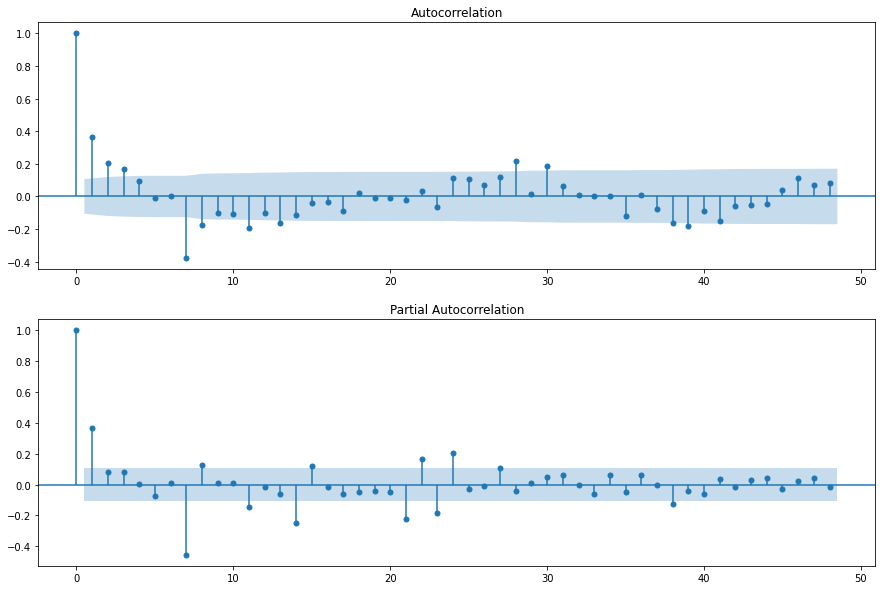

In [24]:
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(train_df.y_diff[13:].values.squeeze(), lags=48, ax=ax)

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(train_df.y_diff[13:].values.squeeze(), lags=48, ax=ax)

In [25]:
ps = range(0, 2)
ds = range(0, 2)
qs = range(0, 4)
Ps = range(0, 4)
Ds = range(0, 3)
Qs = range(0, 2)

In [26]:
from itertools import product

parameters = product(ps, ds, qs, Ps, Ds, Qs)
parameters_list = list(parameters)
len(parameters_list)

384

In [27]:
%%time
import warnings

from tqdm import tqdm

results1 = []
best_aic = float("inf")
warnings.filterwarnings("ignore")

for param in tqdm(parameters_list):
    # try except is necessary, because on some sets of parameters the model can not be trained
    try:
        model = sm.tsa.statespace.SARIMAX(
            train_df["y"],
            order=(param[0], param[1], param[2]),
            seasonal_order=(param[3], param[4], param[5], 7),
        ).fit(disp=-1)
    # print parameters on which the model is not trained and proceed to the next set
    except (ValueError, np.linalg.LinAlgError):
        continue
    aic = model.aic
    # save the best model, aic, parameters
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results1.append([param, model.aic])

100%|██████████| 384/384 [10:38<00:00,  1.66s/it]Wall time: 10min 38s



In [28]:
result_table1 = pd.DataFrame(results1)
result_table1.columns = ["parameters", "aic"]
print(result_table1.sort_values(by="aic", ascending=True).head())

             parameters          aic
165  (0, 1, 2, 3, 2, 1)  4961.632628
332  (1, 1, 1, 3, 2, 1)  4962.829903
380  (1, 1, 3, 3, 2, 1)  4965.652973
189  (0, 1, 3, 3, 2, 1)  4969.534607
213  (1, 0, 0, 3, 2, 1)  4973.212241


In [29]:
result_table1[
    result_table1["parameters"].isin(
        [(1, 0, 2, 3, 1, 0), (1, 1, 2, 3, 2, 1), (1, 1, 2, 3, 1, 1), (1, 0, 2, 3, 0, 0)]
    )
]

,parameters,aic
255,"(1, 0, 2, 3, 0, 0)",5183.818136
257,"(1, 0, 2, 3, 1, 0)",5022.312525
354,"(1, 1, 2, 3, 1, 1)",5019.555903
356,"(1, 1, 2, 3, 2, 1)",4988.957857


In [30]:
import scipy.stats

train_df["y_box"], lmbda = scipy.stats.boxcox(train_df["y"])
print("The optimal Box-Cox transformation parameter: %f" % lmbda)

The optimal Box-Cox transformation parameter: 0.732841


In [31]:
results2 = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    # try except is necessary, because on some sets of parameters the model can not be trained
    try:
        model = sm.tsa.statespace.SARIMAX(
            train_df["y_box"],
            order=(param[0], param[1], param[2]),
            seasonal_order=(param[3], param[4], param[5], 7),
        ).fit(disp=-1)
    # print parameters on which the model is not trained and proceed to the next set
    except (ValueError, np.linalg.LinAlgError):
        continue
    aic = model.aic
    # save the best model, aic, parameters
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results2.append([param, model.aic])

warnings.filterwarnings("default")

100%|██████████| 384/384 [08:46<00:00,  1.37s/it]


In [32]:
result_table2 = pd.DataFrame(results2)
result_table2.columns = ["parameters", "aic"]
print(result_table2.sort_values(by="aic", ascending=True).head())

             parameters          aic
258  (1, 0, 2, 3, 2, 1)  3528.650822
212  (1, 0, 0, 3, 2, 1)  3530.524249
377  (1, 1, 3, 3, 2, 1)  3531.814724
236  (1, 0, 1, 3, 2, 1)  3532.092311
330  (1, 1, 1, 3, 2, 1)  3534.434776


In [33]:
result_table2[
    result_table2["parameters"].isin(
        [(1, 0, 2, 3, 1, 0), (1, 1, 2, 3, 2, 1), (1, 1, 2, 3, 1, 1), (1, 0, 2, 3, 0, 0)]
    )
].sort_values(by="aic")

,parameters,aic
353,"(1, 1, 2, 3, 2, 1)",3534.540192
255,"(1, 0, 2, 3, 1, 0)",3556.880030
352,"(1, 1, 2, 3, 1, 1)",3557.851454
254,"(1, 0, 2, 3, 0, 0)",3674.916118


**Вопрос 5**: Далее перейдем к построению модели SARIMAX (`sm.tsa.statespace.SARIMAX`). Модель c какими параметрами лучшая по `AIC`-критерию?

In [34]:
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               y_box   No. Observations:                  353
Model:             SARIMAX(1, 0, 2)x(3, 2, [1], 7)   Log Likelihood               -1756.325
Date:                             Tue, 02 Mar 2021   AIC                           3528.651
Time:                                     22:52:56   BIC                           3559.259
Sample:                                          0   HQIC                          3540.848
                                             - 353                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8195      0.118      6.961      0.000       0.589       1.050
ma.L1         -0.3355      

Student's test: p=0.114825
Dickey-Fuller test: p=0.000000


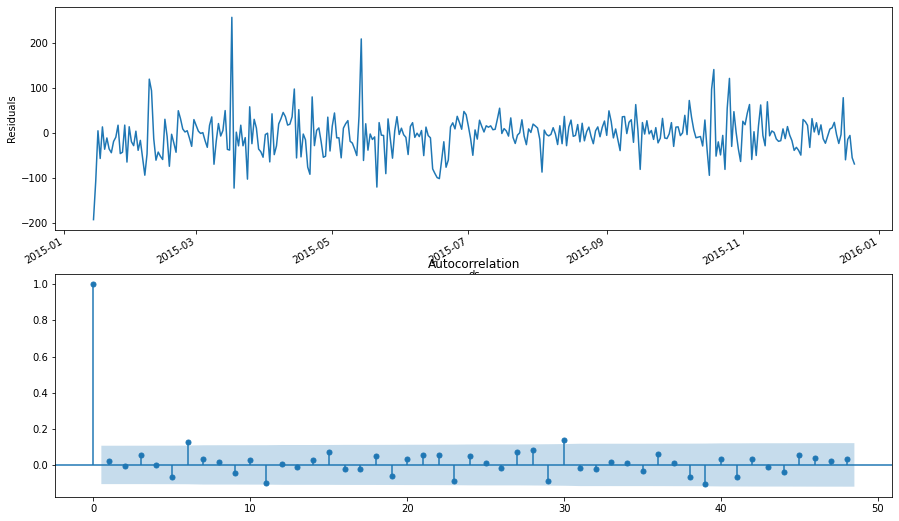

In [35]:
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u"Residuals")

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Student's test: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

In [36]:
def invboxcox(y, lmbda):
    # reverse Box Cox transformation
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda * y + 1) / lmbda)

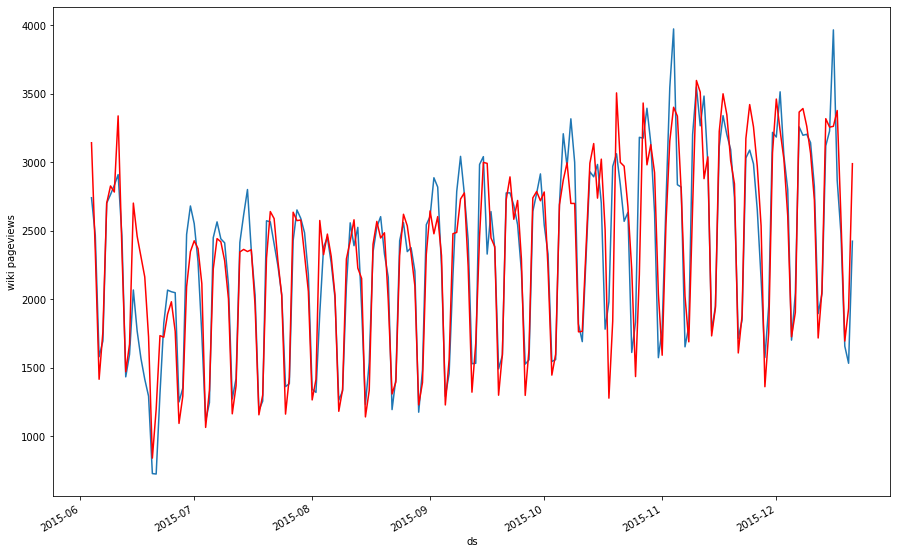

In [37]:
train_df["arima_model"] = invboxcox(best_model.fittedvalues, lmbda)

train_df.y.tail(200).plot()
train_df.arima_model[13:].tail(200).plot(color="r")
plt.ylabel("wiki pageviews");